# How different weather conditions induce forest fires in Algeria

# Introduction

Climate change is causing changes in weather conditions that have the potential of inducing forest fires around the world. Located on the Mediterranean coast, Algeria houses several endangered species, like the prickly juniper. However, because Algeria's hot, dry climate increases the rate of evaporation, plants are drier than usual, and, consequently, increase the occurrence of forest fires. Thus, it is important to combat this environmental issue to prevent further decimation and degradation of Algerian forests. 

The dataset used in analyses is from center of Machine Learning and Intelligent System of University of california. This center mainly focus on the research of Machine learning and intelligent system, which is aimed to develop computer algorithms in order to solve real world problem in 21st century. The sepecific dataset used in our analyses is called Algerian forest Fires dataset, it includes two regions which are Bejaia (Northeast of Algeria) and Sidi Bel-abbes (Northwest of Algeria). The dataset includes 122 observations for each region, and the period is form June 2012 to September 2012. We chose the Bejaia region for analysis, because after we brief explore the some geographic information of two regions, we found that Bejaia is a costal city which will better represent the characristics Mediterranean climate. 

Focusing on the Bejaia region from the Algerian Forest Fires dataset, which contains numerical data on relative humidity, wind speed, rain, and temperature, we will use the aforementioned variables as predictors to evaluate their predictive values and determine how well they predict the occurrence of forest fires in Bejaia. 

# Literature Review

"Fire Activity in Mediterranean Forests (The Algerian Case)" by Thomas Curt, Aissa Aini and Sylvain Dupire. 

In this article, authors analyse the causes of fire based on climate and biodiversity in northern area of Algerian. They illustrated that the fire occur most often at thoses areas with high degree of biodiversity. The paper shows that due to the special characteristics of Mediterranean climate, the summer in those areas is dry and high-temperature. The biomass produced by plant during rainy season becomes fuel which could easily carry the fire during the dry season. Also the other areas of Algerian where the aridity reduces the biodiversity and also the biomass, this could explain the other areas with lower rainfall but less fires occur. Authors also mentioned human activity could also be a source of forest fire. The dataset used in this paper is from FIRMS website, it provides the point-data on the active fire burning while the satellite passed. Based on this paper, we could provide a better analyses on the predictors of Relative Humidity and Rain. 

"Fire activity in mediterranean forests (the algerian case)."

# Methods and Results

## **NEW**
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
     - loads data from the original source on the web 
     - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
     - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
     - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
     - performs the data analysis
     - creates a visualization of the analysis 
     - note: all tables and figure should have a figure/table number and a legend


#### **From methods section in proposal**

- We will be using the K-nearest neighbour classification system, with predictors: relative humidity, wind speed, rain, and temperature, to classify new observations as "fire" or "not fire". 

    - First, we split the data set into a training set and a testing set. Then, the training set is further split into a training set and a validation set so that we can tune our model and perform a 5-fold cross-validation to choose a K-value that gives the most accurate predictions. 

    - Additionally, we will standardize the data, by scaling and centering the data so the average will be 0 and the standard deviation will be 1, to ensure all variables are on a comparable scale to contribute equally in the calculation of the distance between the points. 

    - In general, for each predictor we:
        - calculate the Euclidean distance between the new observation and each observation in the training set, 
        - place the distances in ascending order, 
        - classify the new observation to a class 


- Results will be visualized with a 4x4 group of scatterplots (and their respective distributions), where points are coloured by classes, and, therefore, will show the relationships between each variable.


In [1]:
# Loading packages
library(dplyr)
library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
library(cowplot)

Warning message:
“package ‘dplyr’ was built under R version 4.0.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.0
✔ readr   1.3.1     

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ b

## Exploratory Data Analysis

In [2]:
# Reading and tidying data from the web

# read .csv file
algerian_fire <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)

# select the Bajaia region data and set up the right labels
bejaia_fire_0 <- algerian_fire[c(1:122), ]
bejaia_fire <- bejaia_fire_0 %>% 
                 select(day, month, year, Classes, Temperature, RH, Ws, Rain) %>%
                 mutate(Temperature = as.numeric(Temperature)) %>%
                 mutate(RH = as.numeric(RH)) %>%
                 mutate(Ws = as.numeric(Ws)) %>%
                 mutate(Rain = as.numeric(Rain)) 

# combine three columns and set it as date
bejaia_fire$date <- as.Date(with(bejaia_fire, paste(year, month, day, sep="-")), "%Y-%m-%d") 

# tidy the whole dataset
bejaia_fire_tidy <- bejaia_fire %>% 
                    select(date, Classes,Temperature, RH, Ws, Rain)

In [3]:
# Creating the training dataset

# remove space before and after the string
bejaia_fire_tidy$Classes <- trimws(bejaia_fire_tidy$Classes)

# set the label back to factor
bejaia_fire_tidy <- bejaia_fire_tidy %>% 
                    mutate(Classes = as.factor(Classes)) 

# split and get training and testing dataset
bejaia_split <- initial_split(bejaia_fire_tidy, prop = 0.75, strata = Classes)
bejaia_train <- training(bejaia_split)
bejaia_test <- testing(bejaia_split)

In [4]:
# Creating a table for the number of observations for each class

set.seed(80)

bejaia_table <- bejaia_train %>%
                group_by(Classes)%>%
                summarize(n = n())

'Table 1: Number of Observations for Each Class'
bejaia_table

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Table 1: Number of Observations for Each Class"

Classes,n
<fct>,<int>
fire,45
not fire,48


In [5]:
# Preparing the training data for visualization

# preprocess and standardize data by centering and scaling
bejaia_recipe <- recipe(Classes ~ Temperature + RH + Ws + Rain, data = bejaia_train) %>% 
                 step_center(all_predictors()) %>%
                 step_scale(all_predictors())

# apply trained data recipe
bejaia_scaled <- bejaia_recipe %>%  
                 prep() %>%
                 bake(bejaia_train)

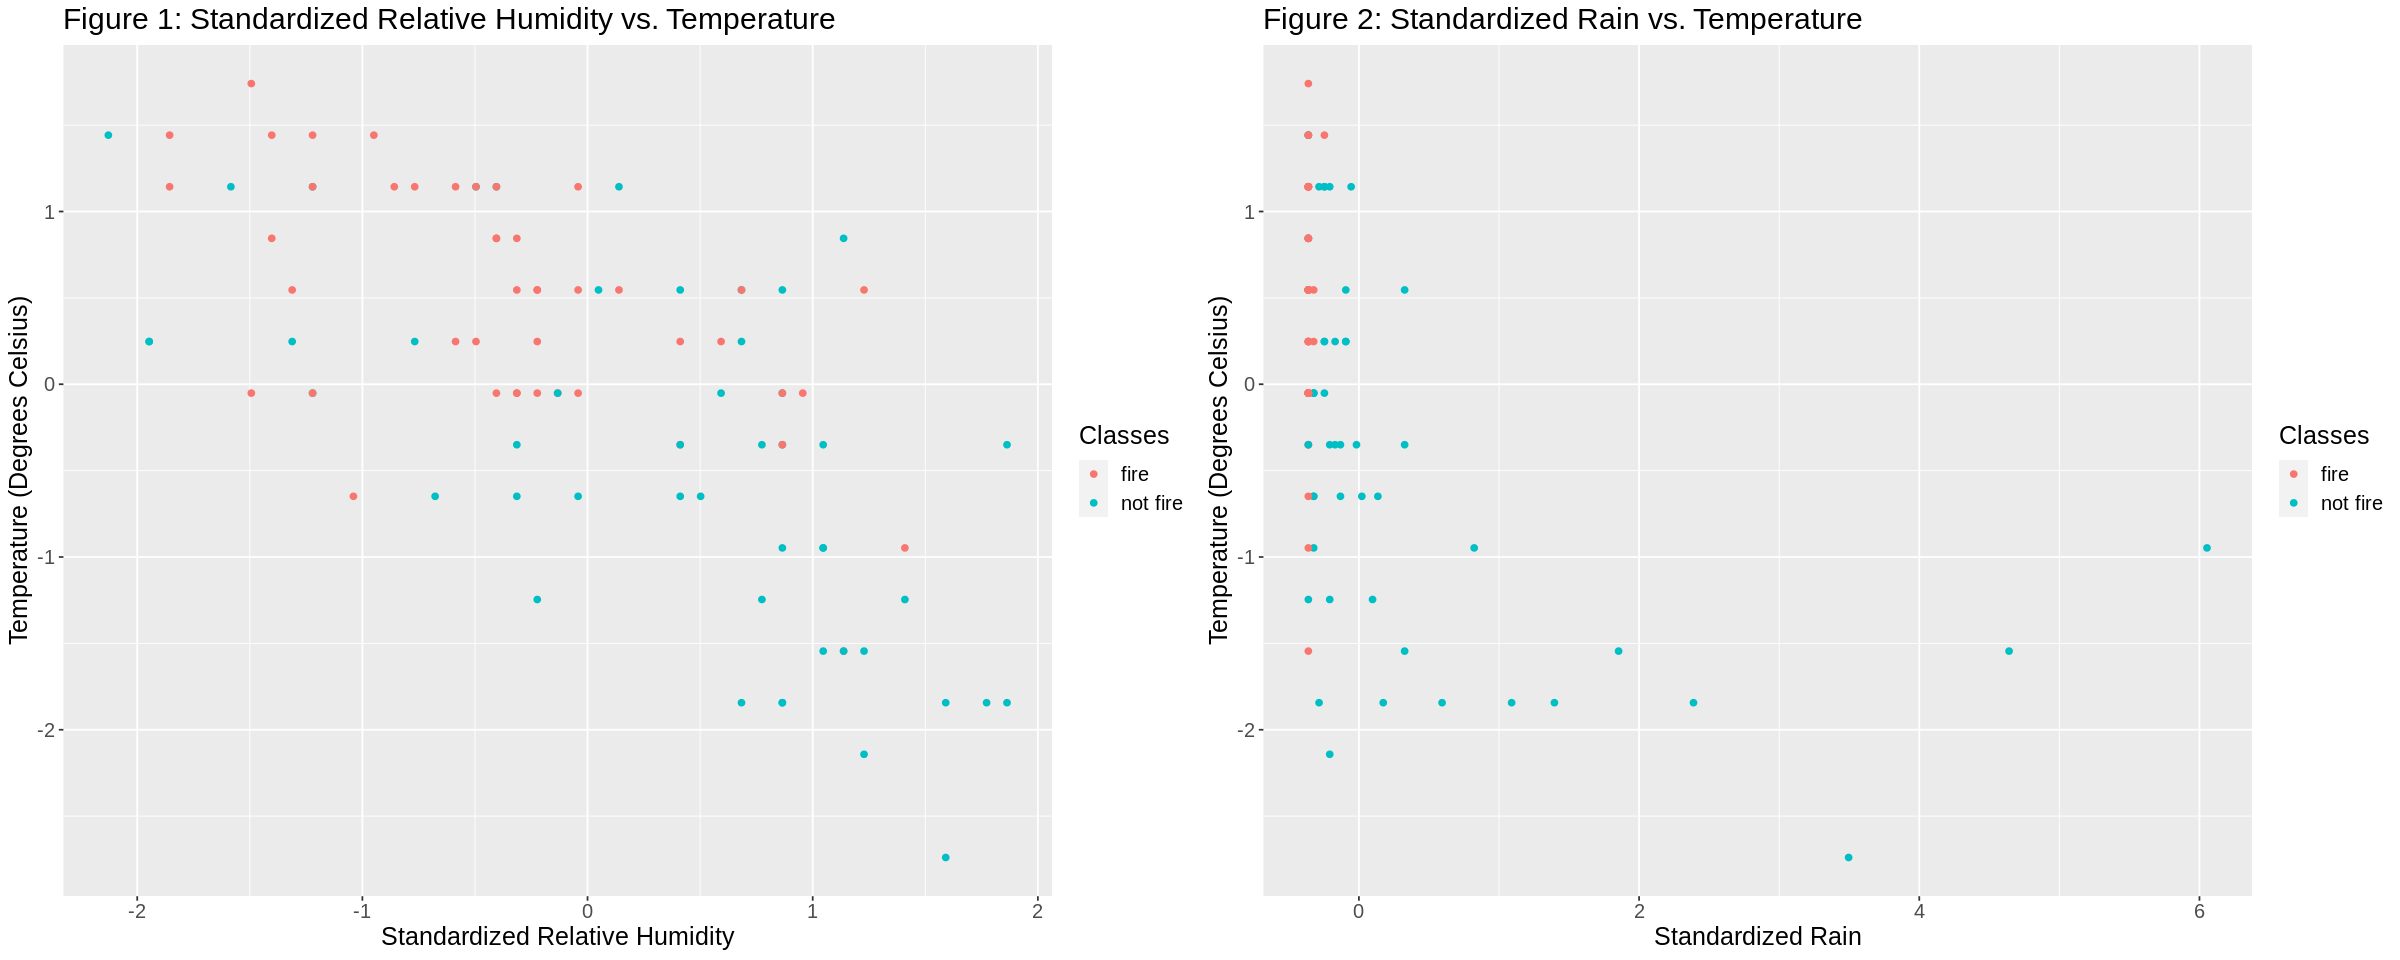

In [6]:
# The exploratory visualization 

options(repr.plot.width = 20, repr.plot.height = 8)

# Standardized Relative Humidity vs. Temperature plot
b_RH_plot <- bejaia_scaled %>% 
             ggplot(aes(x = RH, y = Temperature, color = Classes)) + 
             geom_point() + 
             ggtitle("Figure 1: Standardized Relative Humidity vs. Temperature") +
             labs(x = "Standardized Relative Humidity", y = "Temperature (Degrees Celsius)", colour = "Classes")+
             theme(text = element_text(size = 15))

# Standardized Rain vs. Temperature plot
b_Ws_plot <- bejaia_scaled %>% 
             ggplot(aes(x = Rain, y = Temperature, color = Classes)) + 
             geom_point() + 
             ggtitle("Figure 2: Standardized Rain vs. Temperature") +
             labs(x = "Standardized Rain", y = "Temperature (Degrees Celsius)", colour = "Classes") +
             theme(text = element_text(size = 15))

plot_grid(b_RH_plot, b_Ws_plot)

In Figure 1, we can see that a large number of red data points, indicating that a forest fire occurred, with an increase in temperature and a decrease in the amount of relative humidity. Namely, when the temperature is above 0.5 degrees celsius and when the standardized relative humidity is below 1. Hence, temperature and relative humidity are good predictors to predict the occurence of forest fires.

In Figure 2, we can see a larger number of red data points indicating that forest fires are more likely to occur when temperature increases and when the amount of rainfall is lower. Hence, temperature and rain are good predictors to predict the occurence of forest fires.

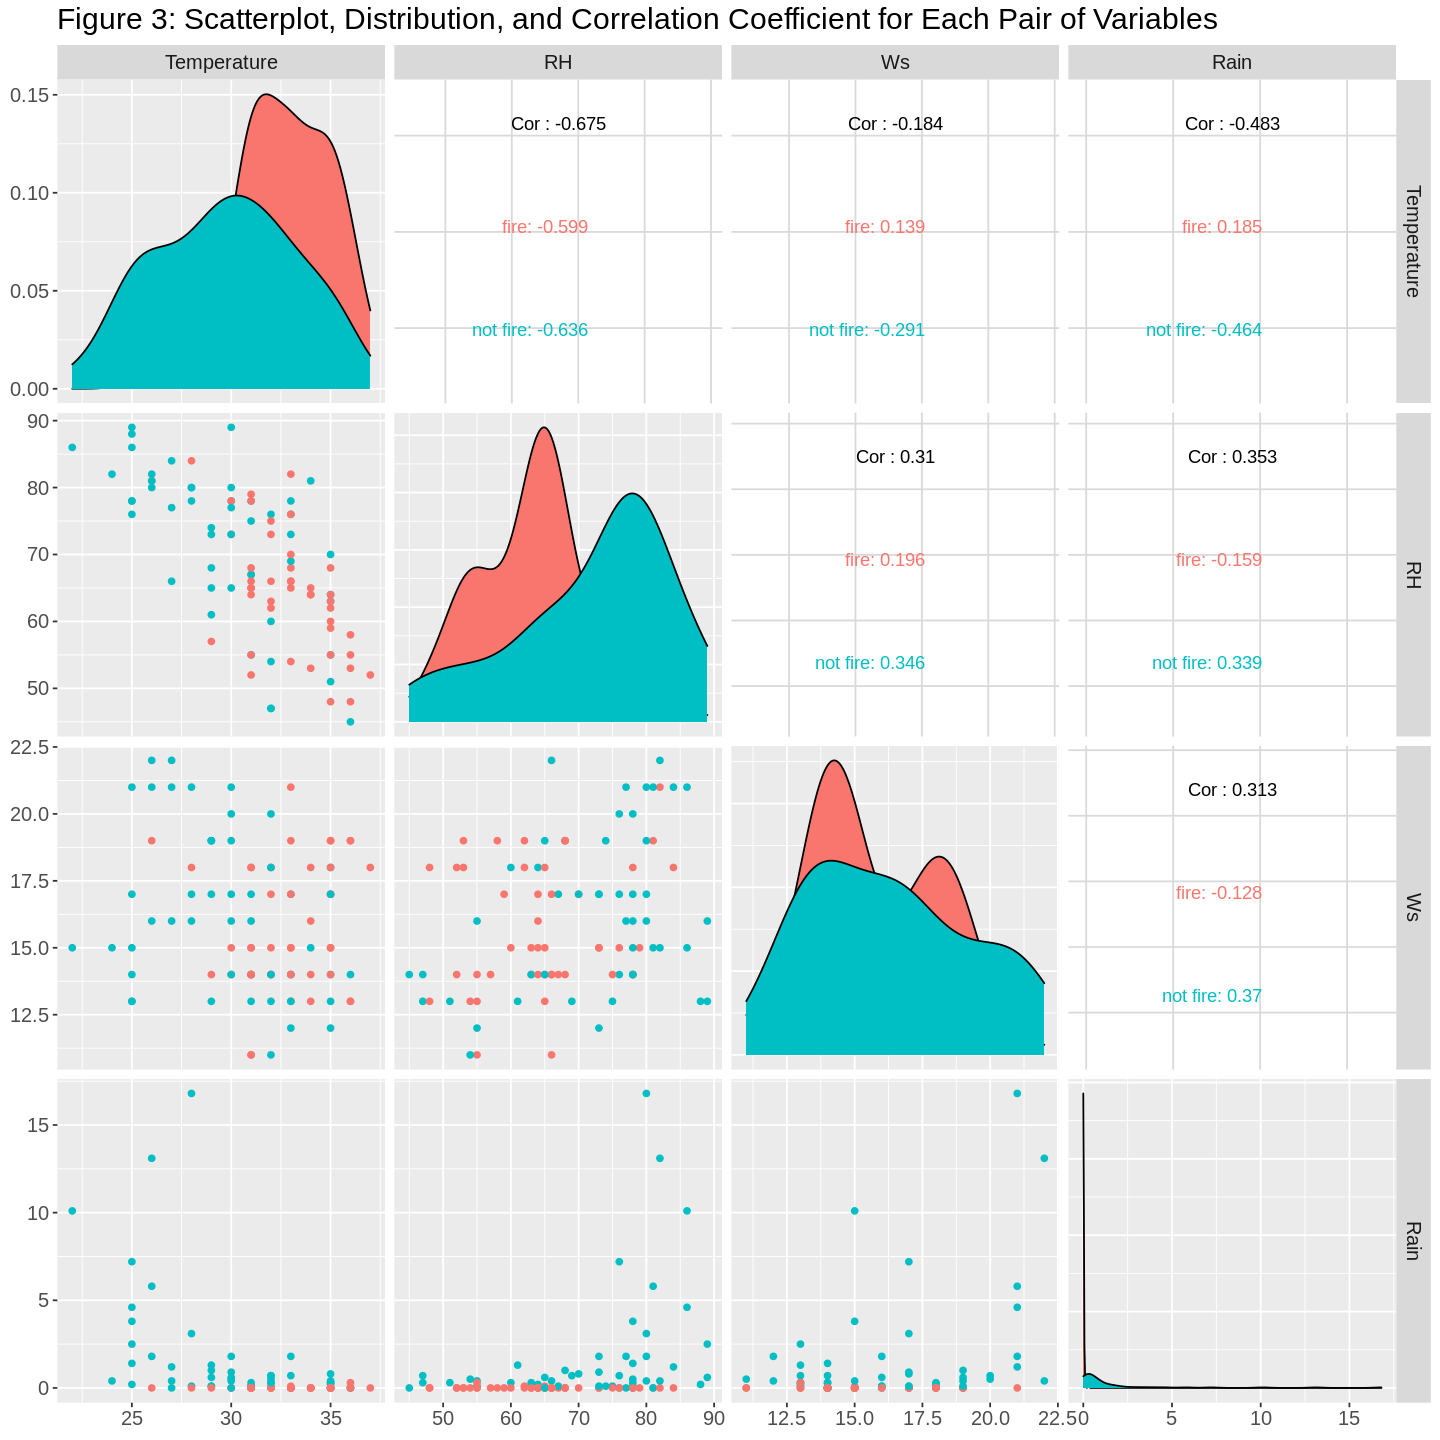

In [7]:
# The final exploratory visualization

options(repr.plot.width = 12, repr.plot.height = 12)

pairs_bejaia <- bejaia_train %>%
                select(Temperature, RH, Ws, Rain) %>%
                ggpairs(ggplot2::aes(colour = bejaia_train$Classes)) +
                ggtitle("Figure 3: Scatterplot, Distribution, and Correlation Coefficient for Each Pair of Variables") +
                theme(text = element_text(size = 15))
pairs_bejaia

### **TODO: add description**

# Data Analysis

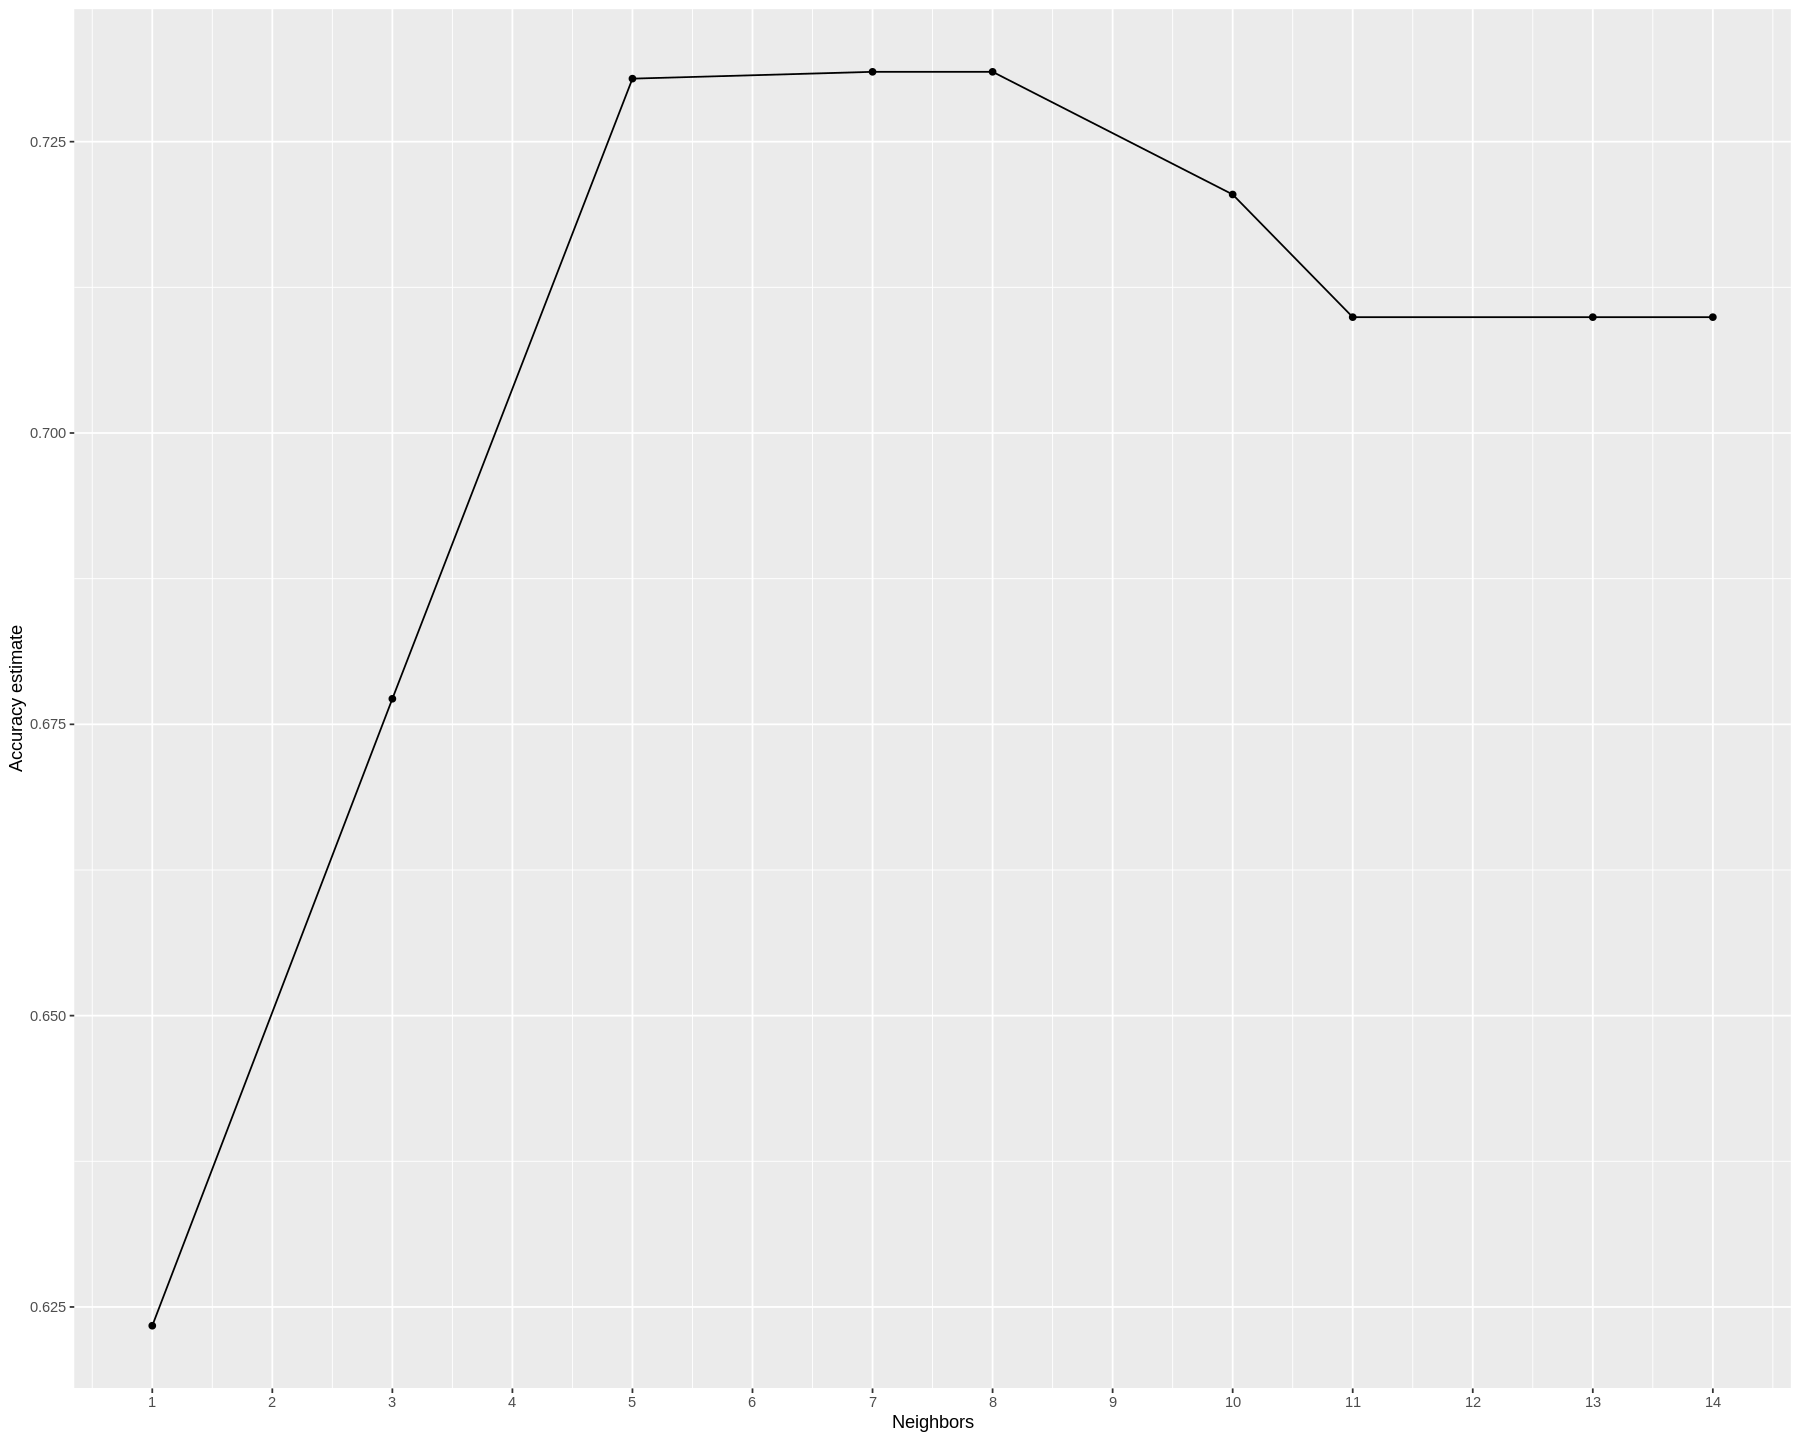

In [10]:
# Finding the best K

set.seed(80)  # because of cross-validation, we need to set a seed to prevent getting a different plot everytime

bejaia_recipe_1 <- recipe(Classes ~ Temperature + RH + Ws + Rain, data = bejaia_train) %>% 
                 step_center(all_predictors()) %>%
                 step_scale(all_predictors()) #set up recipe and scale all predictors

bejaia_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification") #set up model 

bejaia_vfold <- vfold_cv(bejaia_train, v = 5, strata = Classes)

bejaia_workflow <- workflow() %>%
            add_recipe(bejaia_recipe) %>%
            add_model(bejaia_spec) %>%
            tune_grid(resamples = bejaia_vfold, grid = 10) %>%
            collect_metrics() 

bejaia_accuracy <- bejaia_workflow %>% 
                filter(.metric == "accuracy")

options(repr.plot.width = 15, repr.plot.height = 12)

accuracy_plot <- bejaia_accuracy %>% 
                ggplot(aes(x = neighbors, y = mean)) + 
                geom_point() + 
                geom_line() + 
                xlab("Neighbors") + 
                ylab("Accuracy estimate") +
                scale_x_continuous(breaks = seq(0, 14, by = 1))   # adjusting the x-axis
accuracy_plot

From the graph, when $K = #$ or $K = #$ will produce the best accuracy.

In [9]:
set.seed(80)

bejaia_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

bejaia_result <- workflow() %>%
                add_recipe(bejaia_recipe) %>%
                add_model(bejaia_spec_best) %>%
                fit(data = bejaia_train)

bejaia_predict <- predict(bejaia_result, bejaia_test) %>%
                bind_cols(bejaia_test)

accuracies <- bejaia_predict %>%
            metrics(truth = Classes, estimate = .pred_class) %>%
            filter(.metric == "accuracy") %>%
            select(.estimate) %>%
            pull()

# confusion matrix
bejaia_conf <- bejaia_predict %>%
            conf_mat(truth = Classes, estimate = .pred_class)
bejaia_conf

          Truth
Prediction fire not fire
  fire       12        6
  not fire    2        9

The confusion matrix shows us that $#$ observations were correctly labelled. And $#$ observations as not fires when they were truly fires and $#$ observations as fires when they were in fact not fires.

# Discussion

## **NEW**
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?


We expect to find that as temperature and wind speed increases and humidity and rain decreases, forest fires are more likely to occur.

The significance of deciding which factors are able to accurately predict when a forest fire is likely to occur is important in planning to mitigate the effects or preventing them altogether if we have sufficient warning. This way, inhabitants could take the necessary precautions to prevent fire propagation and preserve the environment and reduce air pollution. If a forest fire is predicted and easily detected, the fire can be more quickly extinguished. 

The results of our analysis lead to many unexplored questions. Future analyses could focus on which specific weather conditions have the most significant impact on determining the occurrence of forest fires. 


---

# References

AINI, A., CURT, T., & BEKDOUCHE, F. (2019). Modelling fire hazard in the southern mediterranean fire rim (bejaia region, northern algeria). Environmental Monitoring and Assessment, 191(12), 1-19. https://doi.org/10.1007/s10661-019-7931-0

Curt, T., Aini, A., & Dupire, S. (2020). Fire activity in mediterranean forests (the algerian case). Fire (Basel, Switzerland), 3(58), 58. https://doi.org/10.3390/fire3040058